In [1]:
import pandas as pd
import numpy as np

import os
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
import librosa.display
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, AveragePooling1D, Flatten, Dropout, BatchNormalization, Input
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
Features = pd.read_csv('../../data/features_gender_final.csv')

In [4]:
Features = Features.fillna(0)
print(Features.isna().any())
Features.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(31584, 2377)

In [5]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [6]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
encoder.categories_

[array(['female', 'male'], dtype=object)]

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.15, random_state=30, shuffle=True,stratify=Y)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((26846, 2376), (26846, 2), (4738, 2376), (4738, 2))

In [8]:
scaler = StandardScaler()

In [9]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, random_state=30, test_size=0.25, shuffle=True,stratify=y_test)
x_train.shape, x_test.shape, x_val.shape, x_train.shape, x_test.shape, x_val.shape

((26846, 2376),
 (3553, 2376),
 (1185, 2376),
 (26846, 2376),
 (3553, 2376),
 (1185, 2376))

In [10]:
x_train = scaler.fit_transform(x_train)
x_val=scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((26846, 2376), (26846, 2), (3553, 2376), (3553, 2))

In [11]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((26846, 2376, 1), (26846, 2), (3553, 2376, 1), (3553, 2))

In [12]:
def CNN_maker(name, x_train, y_train):
    input_layer = Input(shape=(x_train.shape[1], 1))

    # 1
    hl = Conv1D(512, kernel_size=3, strides=1, padding='same', activation='relu')(input_layer)
    hl = BatchNormalization()(hl)
    hl = AveragePooling1D(pool_size=3, strides=2, padding='same')(hl)
    hl = Dropout(0.3)(hl)

    #2

    hl = Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu')(hl)
    hl = BatchNormalization()(hl)
    hl = AveragePooling1D(pool_size=3, strides=2, padding='same')(hl)
    hl = Dropout(0.3)(hl)

    #3

    hl = Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu')(hl)
    hl = BatchNormalization()(hl)
    hl = AveragePooling1D(pool_size=3, strides=2, padding='same')(hl)
    hl = Dropout(0.3)(hl)

    # Flatten layer
    hl = Flatten()(hl)

    # Dense layers for the shared layer
    hl = Dense(64, activation='relu')(hl)
    hl = BatchNormalization()(hl)
    hl = Dropout(0.3)(hl)

    output = Dense(y_train.shape[1], activation='softmax', name=name)(hl)

    return Model(inputs=input_layer, outputs=[output])

In [13]:
model = CNN_maker("gender", x_train, y_train)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-09-09 00:20:06.237876: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-09 00:20:06.237899: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2376, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 2376, 512)         2048      
                                                                 
 batch_normalization (BatchN  (None, 2376, 512)        2048      
 ormalization)                                                   
                                                                 
 average_pooling1d (AverageP  (None, 1188, 512)        0         
 ooling1D)                                                       
                                                                 
 dropout (Dropout)           (None, 1188, 512)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 256)         393472

In [15]:
optimizer = keras.optimizers.Nadam()

In [16]:
model.compile(optimizer=optimizer,
              loss={'gender': 'binary_crossentropy'},
              metrics={'gender': 'accuracy'})

In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=3)
callbacks=[learning_rate_reduction,early_stop]

In [18]:
history = model.fit(x_train, y_train, batch_size=16, epochs=100, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/100


2023-09-09 00:20:06.660730: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-09 00:20:07.436927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1678/1678 [==============================] - ETA: 0s - loss: 0.5882 - accuracy: 0.6906

2023-09-09 00:21:57.521330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1678/1678 [==============================] - 112s 65ms/step - loss: 0.5882 - accuracy: 0.6906 - val_loss: 0.7792 - val_accuracy: 0.6203 - lr: 0.0010
Epoch 2/100
1678/1678 [==============================] - 109s 65ms/step - loss: 0.3813 - accuracy: 0.8317 - val_loss: 0.3628 - val_accuracy: 0.8219 - lr: 0.0010
Epoch 3/100
1678/1678 [==============================] - 108s 64ms/step - loss: 0.2964 - accuracy: 0.8749 - val_loss: 0.2938 - val_accuracy: 0.8768 - lr: 0.0010
Epoch 4/100
1678/1678 [==============================] - 109s 65ms/step - loss: 0.2480 - accuracy: 0.8983 - val_loss: 0.1997 - val_accuracy: 0.9232 - lr: 0.0010
Epoch 5/100
1678/1678 [==============================] - 108s 65ms/step - loss: 0.2099 - accuracy: 0.9159 - val_loss: 0.1705 - val_accuracy: 0.9359 - lr: 0.0010
Epoch 6/100
1678/1678 [==============================] - 108s 65ms/step - loss: 0.1807 - accuracy: 0.9290 - val_loss: 0.1593 - val_accuracy: 0.9418 - lr: 0.0010
Epoch 7/100
1678/1678 [=======================

In [19]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

112/112 [==============================] - 3s 27ms/step - loss: 0.1207 - accuracy: 0.9536
Accuracy of our model on test data :  95.35603523254395 %


In [20]:
# epochs = list(range(early_stop.stopped_epoch+1))
# fig, ax = plt.subplots(1,2)
# train_acc = history.history['accuracy']
# train_loss = history.history['loss']
# test_acc = history.history['val_accuracy']
# test_loss = history.history['val_loss']

# fig.set_size_inches(20,6)
# ax[0].plot(epochs , train_loss , label = 'Training Loss')
# ax[0].plot(epochs , test_loss , label = 'Testing Loss')
# ax[0].set_title('Training & Testing Loss')
# ax[0].legend()
# ax[0].set_xlabel("Epochs")

# ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
# ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
# ax[1].set_title('Training & Testing Accuracy')
# ax[1].legend()
# ax[1].set_xlabel("Epochs")
# plt.show()

In [21]:
pred_test = model.predict(x_test)

y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

  1/112 [..............................] - ETA: 33s

2023-09-09 00:43:48.707226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


112/112 [==============================] - 3s 26ms/step


In [22]:
pred_test=model.predict(x_test)

112/112 [==============================] - 3s 25ms/step


In [23]:
df_temp = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_temp['Predicted Labels'] = y_pred.flatten()
df_temp['Actual Labels'] = y_test.flatten()

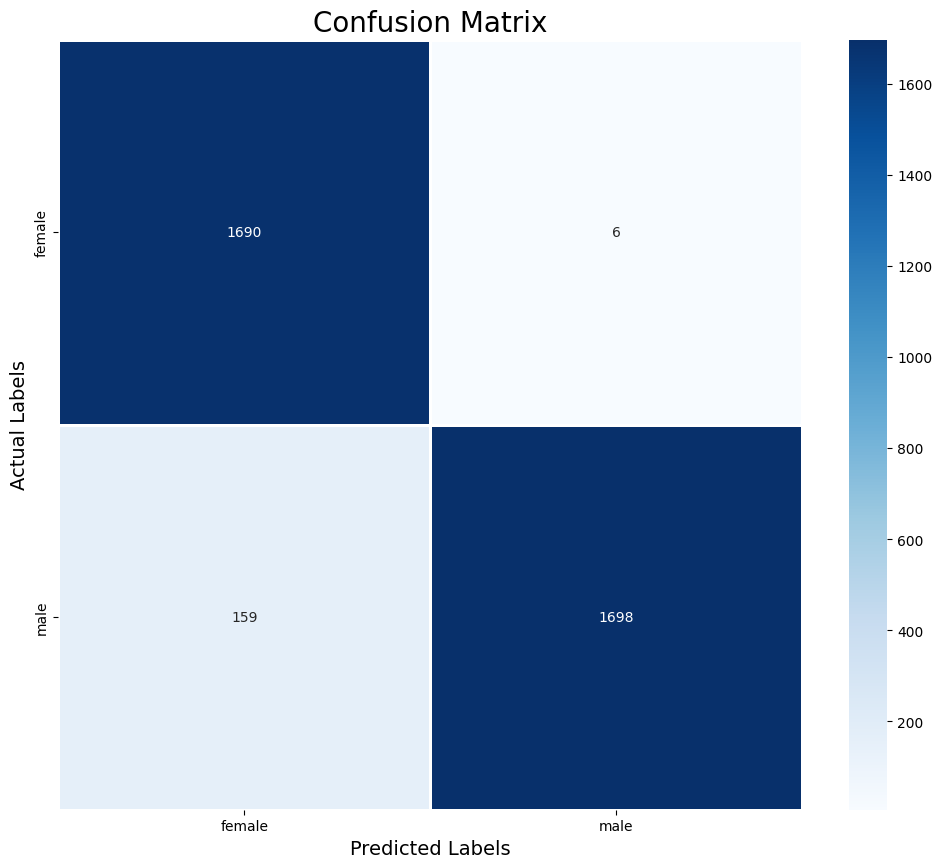

In [24]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm, index=list(encoder.categories_), columns=list(encoder.categories_))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [25]:
print(classification_report(y_test, y_pred, target_names=['male','female']))

              precision    recall  f1-score   support

        male       0.91      1.00      0.95      1696
      female       1.00      0.91      0.95      1857

    accuracy                           0.95      3553
   macro avg       0.96      0.96      0.95      3553
weighted avg       0.96      0.95      0.95      3553



## From voice features and predicted gender, predict age

In [27]:
Features = pd.read_csv('../../data/features_age_final.csv')

In [28]:
Features = Features.fillna(0)
print(Features.isna().any())
Features.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(20228, 2377)

In [29]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [30]:
scaler = StandardScaler()
X1 = scaler.fit_transform(X)
X1 = np.expand_dims(X1, axis=2)

In [31]:
Z=model.predict(X1)

633/633 [==============================] - 16s 25ms/step


In [32]:
Z = encoder.inverse_transform(Z)

In [33]:
Z = Z.flatten()

In [34]:
Features = pd.DataFrame(X)
Features['predicted emotion'] = Z
Features['labels'] = Y

In [35]:
Features

,0,1,2,3,4,5,6,7,8,9,...,2368,2369,2370,2371,2372,2373,2374,2375,predicted emotion,labels
0,0.032715,0.059570,0.076660,0.065918,0.053223,0.031738,0.019531,0.020508,0.020508,0.023926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male,thirties
1,0.035645,0.064453,0.087402,0.078125,0.065918,0.047363,0.035156,0.041016,0.042969,0.041504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male,thirties
2,0.036621,0.057617,0.082031,0.076660,0.060547,0.044922,0.025879,0.020996,0.024414,0.028320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female,thirties
3,0.037598,0.057617,0.083008,0.077637,0.060547,0.045898,0.026855,0.021973,0.025391,0.028320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female,thirties
4,0.014648,0.026367,0.039062,0.043457,0.043945,0.039551,0.067383,0.098633,0.099121,0.107910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male,thirties
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20223,0.020020,0.040527,0.060059,0.062500,0.058105,0.046875,0.037598,0.042480,0.044922,0.047363,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female,twenties
20224,0.010742,0.017578,0.023926,0.027344,0.033691,0.050293,0.069824,0.083984,0.093750,0.086914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female,twenties
20225,0.040039,0.070801,0.101074,0.104004,0.115723,0.110840,0.106934,0.105469,0.096680,0.087891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female,twenties
20226,0.011719,0.019043,0.024414,0.031250,0.048340,0.070312,0.087891,0.099609,0.093262,0.080078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female,twenties


In [36]:
Features['predicted emotion'] = Features['predicted emotion'].astype('category').cat.codes

In [37]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [38]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
encoder.categories_

[array(['fifties', 'forties', 'seventies', 'sixties', 'thirties',
        'twenties'], dtype=object)]

In [39]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.15, random_state=30, shuffle=True,stratify=Y)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17193, 2377), (17193, 6), (3035, 2377), (3035, 6))

In [40]:
scaler = StandardScaler()

In [41]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, random_state=30, test_size=0.25, shuffle=True,stratify=y_test)
x_train.shape, x_test.shape, x_val.shape, x_train.shape, x_test.shape, x_val.shape

((17193, 2377),
 (2276, 2377),
 (759, 2377),
 (17193, 2377),
 (2276, 2377),
 (759, 2377))

In [42]:
x_train = scaler.fit_transform(x_train)
x_val=scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17193, 2377), (17193, 6), (2276, 2377), (2276, 6))

In [43]:
model2 = CNN_maker("age", x_train, y_train)

In [44]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2377, 1)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 2377, 512)         2048      
                                                                 
 batch_normalization_4 (Batc  (None, 2377, 512)        2048      
 hNormalization)                                                 
                                                                 
 average_pooling1d_3 (Averag  (None, 1189, 512)        0         
 ePooling1D)                                                     
                                                                 
 dropout_4 (Dropout)         (None, 1189, 512)         0         
                                                                 
 conv1d_4 (Conv1D)           (None, 1189, 256)         3934

In [45]:
model2.compile(optimizer=optimizer,
              loss={'age': 'categorical_crossentropy'},
              metrics={'age': 'accuracy'})

In [46]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=5, start_from_epoch=20)
callbacks=[learning_rate_reduction,early_stop]



In [47]:
history2=model2.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/100


2023-09-09 00:50:41.501672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


538/538 [==============================] - ETA: 0s - loss: 1.5839 - accuracy: 0.3396

2023-09-09 00:51:46.042314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


538/538 [==============================] - 67s 117ms/step - loss: 1.5839 - accuracy: 0.3396 - val_loss: 1.8175 - val_accuracy: 0.3175 - lr: 5.0000e-04
Epoch 2/100
538/538 [==============================] - 61s 114ms/step - loss: 1.4113 - accuracy: 0.3901 - val_loss: 1.4152 - val_accuracy: 0.3742 - lr: 5.0000e-04
Epoch 3/100
538/538 [==============================] - 60s 112ms/step - loss: 1.3382 - accuracy: 0.4260 - val_loss: 1.3384 - val_accuracy: 0.4427 - lr: 5.0000e-04
Epoch 4/100
538/538 [==============================] - 61s 114ms/step - loss: 1.2707 - accuracy: 0.4620 - val_loss: 1.2984 - val_accuracy: 0.4611 - lr: 5.0000e-04
Epoch 5/100
538/538 [==============================] - 63s 118ms/step - loss: 1.1908 - accuracy: 0.5049 - val_loss: 1.1861 - val_accuracy: 0.5046 - lr: 5.0000e-04
Epoch 6/100
538/538 [==============================] - 66s 122ms/step - loss: 1.0926 - accuracy: 0.5571 - val_loss: 1.1231 - val_accuracy: 0.5402 - lr: 5.0000e-04
Epoch 7/100
538/538 [=============

In [48]:
print("Accuracy of our model on test data : " , model2.evaluate(x_test,y_test)[1]*100 , "%")

72/72 [==============================] - 2s 29ms/step - loss: 0.0524 - accuracy: 0.9842
Accuracy of our model on test data :  98.41827750205994 %


In [49]:
pred_test = model2.predict(x_test)

y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

 1/72 [..............................] - ETA: 16s

2023-09-09 01:35:52.598425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 2s 25ms/step


In [61]:
pred_test=model2.predict(x_test)

72/72 [==============================] - 2s 27ms/step


In [62]:
df_temp2 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_temp2['Predicted Labels'] = y_pred.flatten()
df_temp2['Actual Labels'] = y_test.flatten()

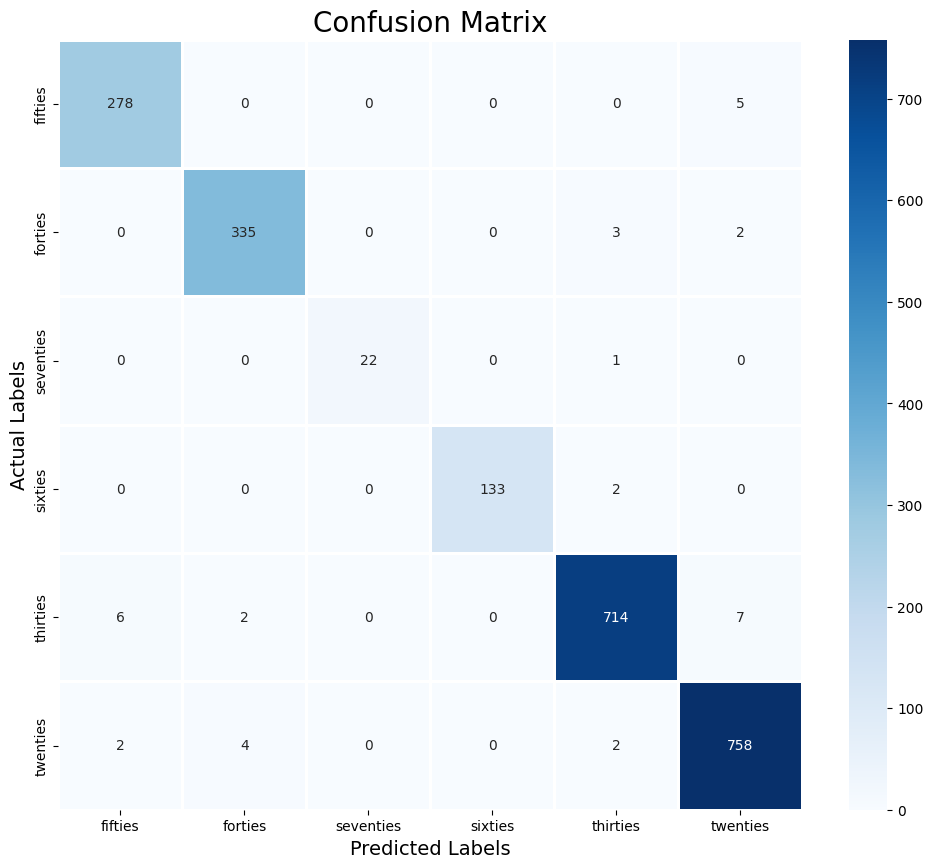

In [63]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm, index=list(encoder.categories_), columns=list(encoder.categories_))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

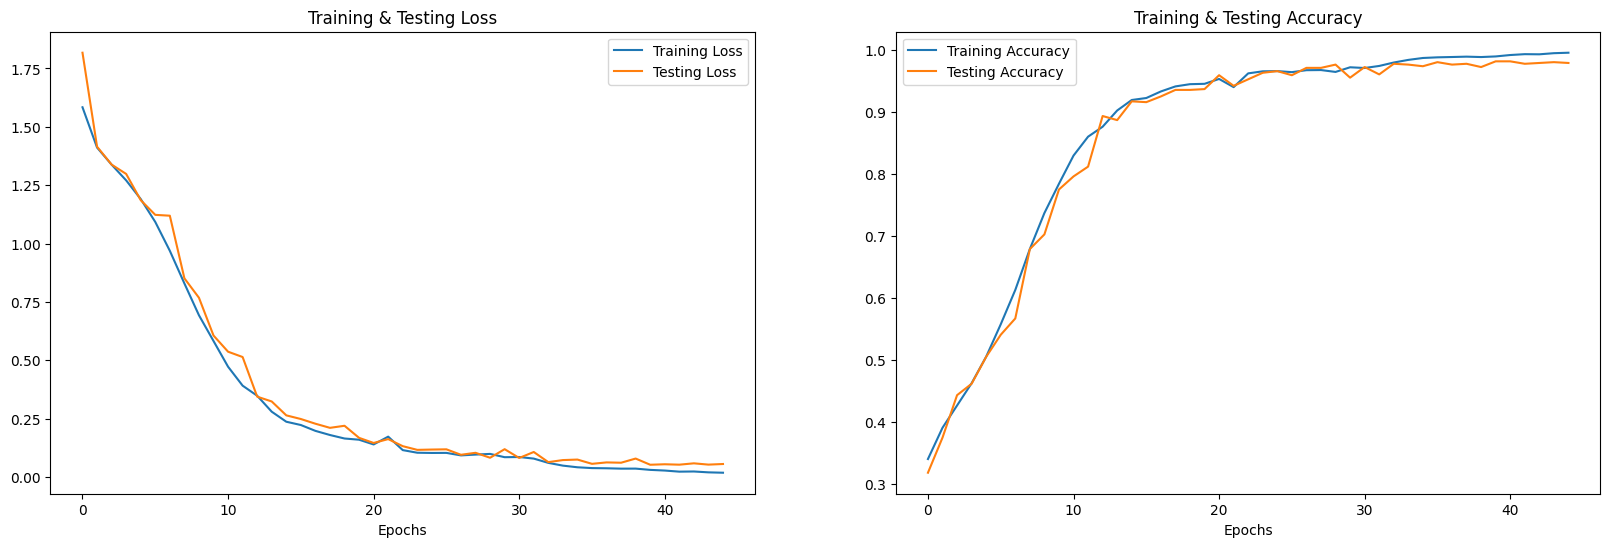

In [64]:
epochs = list(range(early_stop.stopped_epoch+1))
fig , ax = plt.subplots(1,2)
train_acc = history2.history['accuracy']
train_loss = history2.history['loss']
test_acc = history2.history['val_accuracy']
test_loss = history2.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [65]:
print(classification_report(y_test, y_pred, target_names=['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies']))

              precision    recall  f1-score   support

    twenties       0.97      0.98      0.98       283
    thirties       0.98      0.99      0.98       340
     forties       1.00      0.96      0.98        23
     fifties       1.00      0.99      0.99       135
     sixties       0.99      0.98      0.98       729
   seventies       0.98      0.99      0.99       766

    accuracy                           0.98      2276
   macro avg       0.99      0.98      0.98      2276
weighted avg       0.98      0.98      0.98      2276



## From voice features and predicted age, predict emotion

In [72]:
Features = pd.read_csv('../../data/features_emotion_final.csv')

In [73]:
Features = Features.fillna(0)
print(Features.isna().any())
Features.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(20228, 2377)

In [74]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [75]:
scaler = StandardScaler()
X1 = scaler.fit_transform(X)
X1 = np.expand_dims(X1, axis=2)

In [76]:
Z=model2.predict(X1)

InvalidArgumentError: Graph execution error:

Detected at node 'model_1/flatten_1/Reshape' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/kk/vjvtplg11tj3l04qgzpn8mf80000gn/T/ipykernel_76875/3578743921.py", line 1, in <module>
      Z=model2.predict(X1)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/keras/engine/training.py", line 2350, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/keras/engine/training.py", line 2137, in predict_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/keras/engine/training.py", line 2123, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in run_step
      outputs = model.predict_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/keras/engine/training.py", line 2079, in predict_step
      return self(x, training=False)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/prismatic/lib/python3.10/site-packages/keras/layers/reshaping/flatten.py", line 104, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'model_1/flatten_1/Reshape'
Input to reshape is a tensor with 1216512 values, but the requested shape requires a multiple of 38144
	 [[{{node model_1/flatten_1/Reshape}}]] [Op:__inference_predict_function_211029]

In [ ]:
Z = encoder.inverse_transform(Z)

ValueError: could not convert string to float: 'male'

In [ ]:
Z = Z.flatten()

In [ ]:
Features = pd.DataFrame(X)
Features['predicted gender'] = Z
Features['labels'] = Y

In [ ]:
Features['predicted gender'] = Features['predicted gender'].astype('category').cat.codes

In [ ]:
Features

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
encoder.categories_

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.15, random_state=30, shuffle=True,stratify=Y)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
scaler = StandardScaler()

In [ ]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, random_state=30, test_size=0.25, shuffle=True,stratify=y_test)
x_train.shape, x_test.shape, x_val.shape, x_train.shape, x_test.shape, x_val.shape

In [ ]:
x_train = scaler.fit_transform(x_train)
x_val=scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
model3 = CNN_maker("emotion", x_train, y_train)


In [ ]:
model3.summary()

In [ ]:
model3.compile(optimizer=optimizer,
              loss={'emotion': 'categorical_crossentropy'},
              metrics={'emotion': 'accuracy'})

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=5, start_from_epoch=20)
callbacks=[learning_rate_reduction,early_stop]



In [ ]:
history3=model3.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_val, y_val), callbacks=callbacks)

In [ ]:
print("Accuracy of our model on test data : " , model3.evaluate(x_test,y_test)[1]*100 , "%")

In [ ]:
pred_test = model3.predict(x_test)

y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
pred_test=model3.predict(x_test)

In [ ]:
df_temp3 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_temp3['Predicted Labels'] = y_pred.flatten()
df_temp3['Actual Labels'] = y_test.flatten()

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm, index=list(encoder.categories_), columns=list(encoder.categories_))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
epochs = list(range(early_stop.stopped_epoch+1))
fig , ax = plt.subplots(1,2)
train_acc = history3.history['accuracy']
train_loss = history3.history['loss']
test_acc = history3.history['val_accuracy']
test_loss = history3.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=['anger', 'anxiety/fear', 'disgust', 'happiness', 'neutral', 'sad']))